In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
df = pd.read_csv("data/[1h]BTCUSDT.csv")

In [3]:
df.head()

,Start,Stop,Open,Close,Low,High,Volume
0,1502942400000,1502945999999,4261.48,4308.83,4261.32,4313.62,47.181009
1,1502946000000,1502949599999,4308.83,4315.32,4291.37,4328.69,23.234916
2,1502949600000,1502953199999,4330.29,4324.35,4309.37,4345.45,7.229691
3,1502953200000,1502956799999,4316.62,4349.99,4287.41,4349.99,4.443249
4,1502956800000,1502960399999,4333.32,4360.69,4333.32,4377.85,0.972807


### Check stationary

In [4]:
test = adfuller(df.Open.values)
print("ADF Statistic: {0}".format(test[0]))
print("p-value: {0}".format(test[1]))

if test[0] < test[4]["5%"]:
    print ("\nStationary")
else:
    print ("\nNon-Stationary")

ADF Statistic: 1.546089320562305
p-value: 0.9976864785214101

Non-Stationary


### Stationarize

In [5]:
Open_stationary = df.Open.diff(1).dropna()

In [6]:
test = adfuller(Open_stationary, autolag='AIC')
print('p-value: {0}'.format(test[1]))

p-value: 0.0


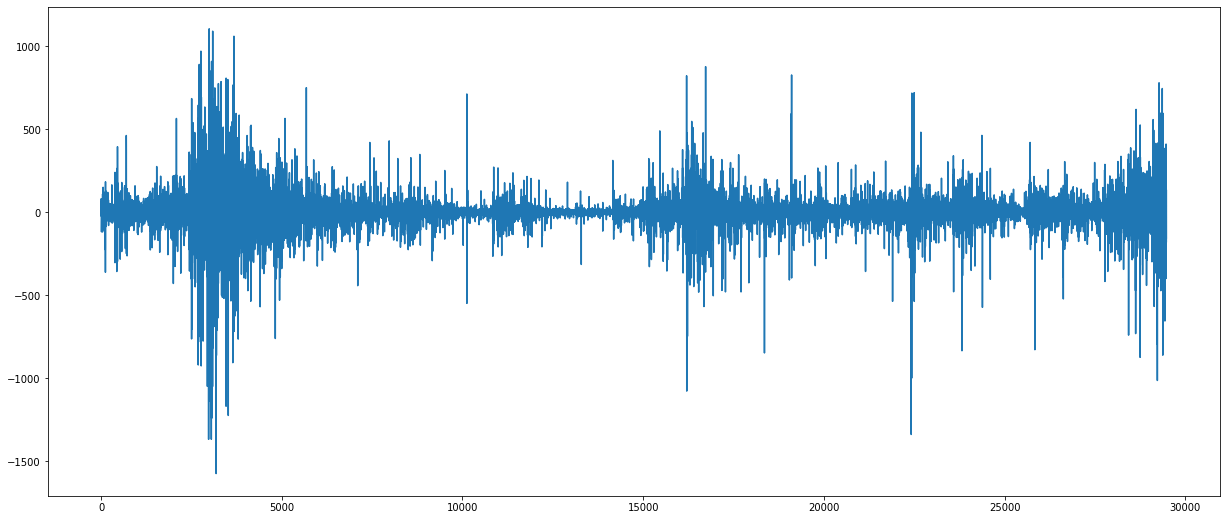

In [7]:
plt.figure(figsize=(21, 9))
plt.plot(Open_stationary)

### PACF and ACF

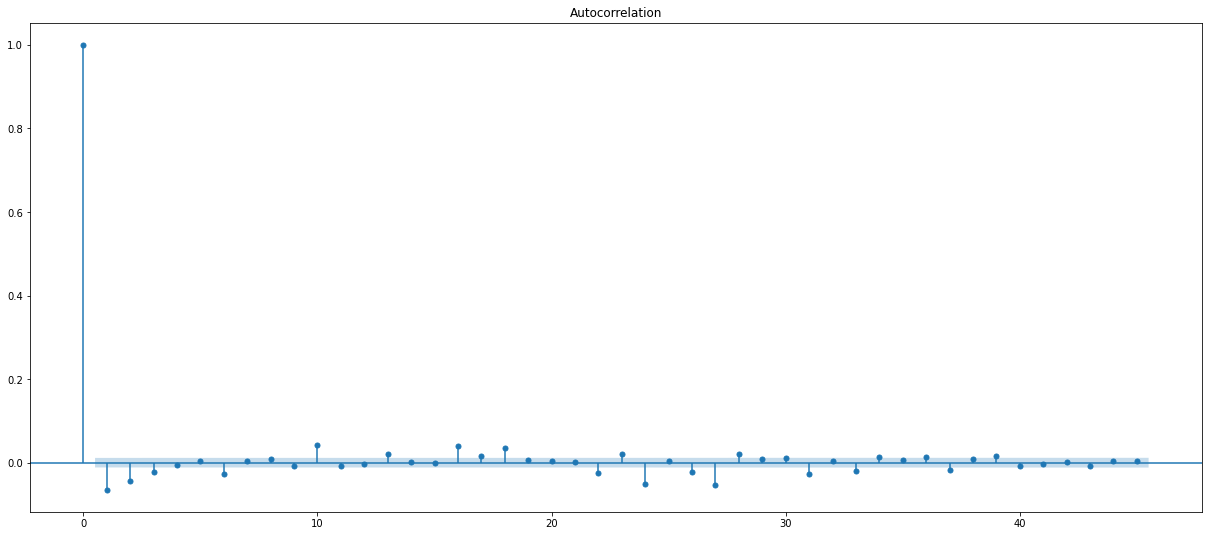

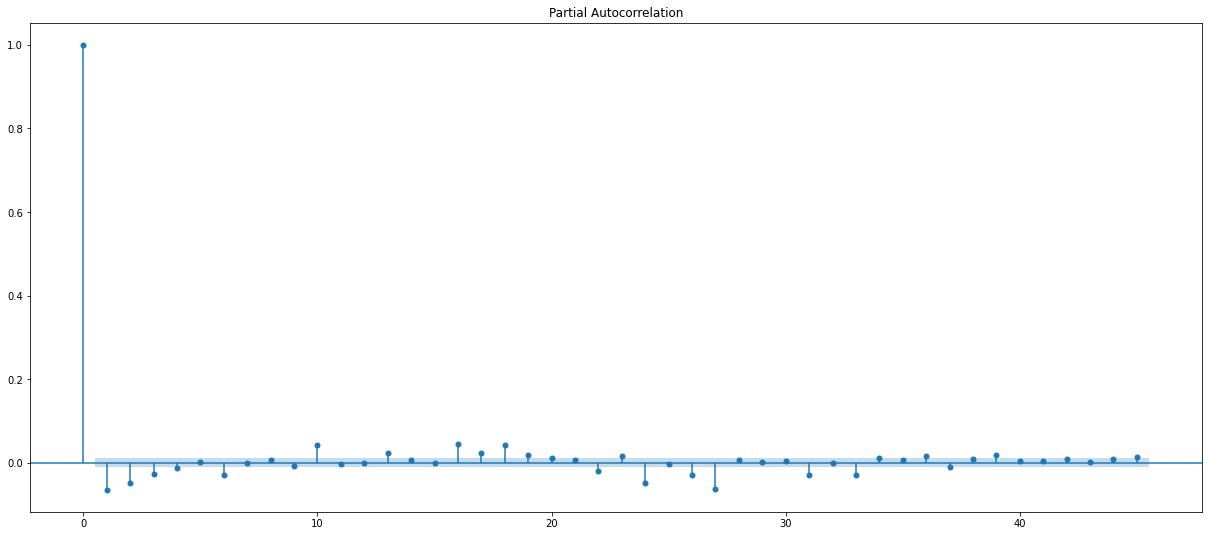

In [8]:
plt.rc("figure", figsize=(21, 9))

plot_acf(Open_stationary)
plt.show()

plot_pacf(Open_stationary)
plt.show()

p = 4

q = 3

# Autoregression (AR)

/home/ufemah/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/ufemah/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/ufemah/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/home/ufemah/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No sup

<Figure size 1512x648 with 0 Axes>

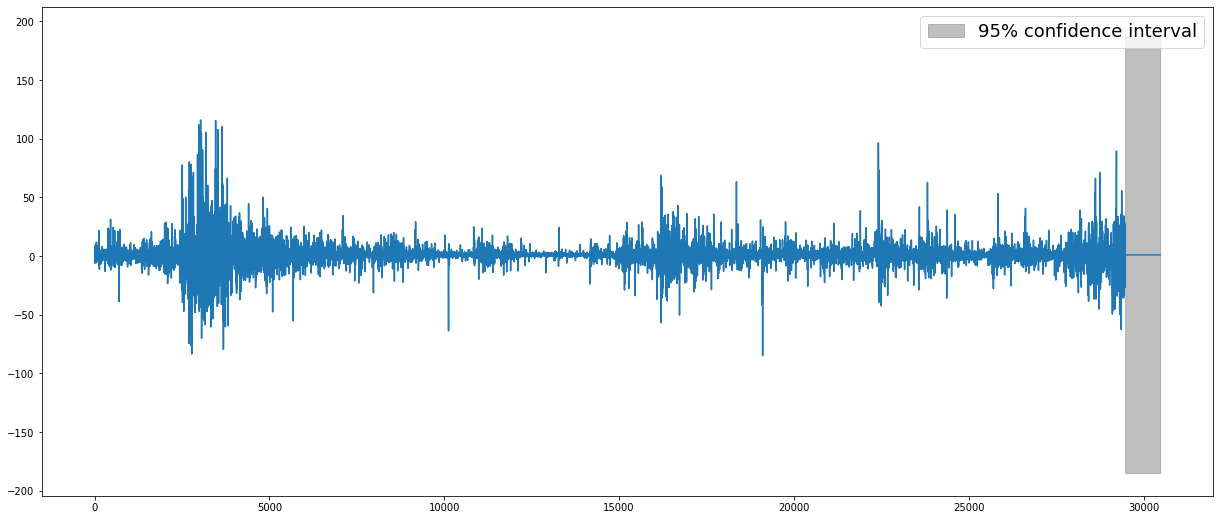

In [13]:
from statsmodels.tsa.ar_model import AutoReg

model_ar = AutoReg(Open_stationary, lags=4, old_names=False).fit()

plt.figure(figsize=(21, 9))

model_ar.plot_predict(0, len(Open_stationary)+1000)

plt.legend(fontsize=18)

# Moving Average (MA)

/home/ufemah/.local/lib/python3.8/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/ufemah/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored wh

<Figure size 1512x648 with 0 Axes>

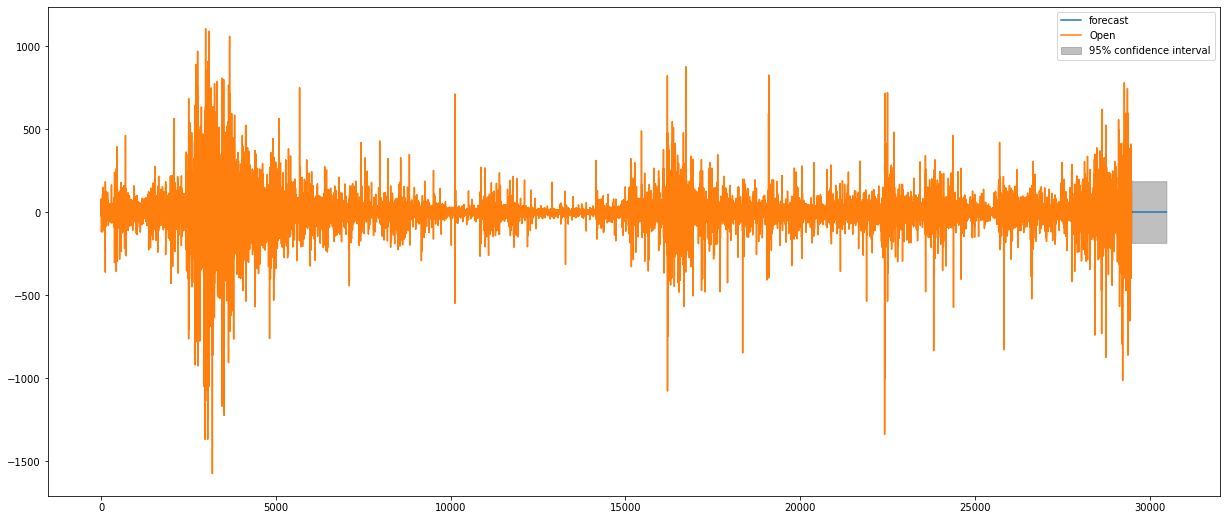

In [11]:
from statsmodels.tsa.arima_model import ARIMA

model_ma = ARIMA(Open_stationary, order=(0, 0, 3)).fit()

plt.figure(figsize=(21, 9))

model_ma.plot_predict(start=0, end=len(Open_stationary)+1000)

plt.show()

# SimpleExpSmoothing

/home/ufemah/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/ufemah/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


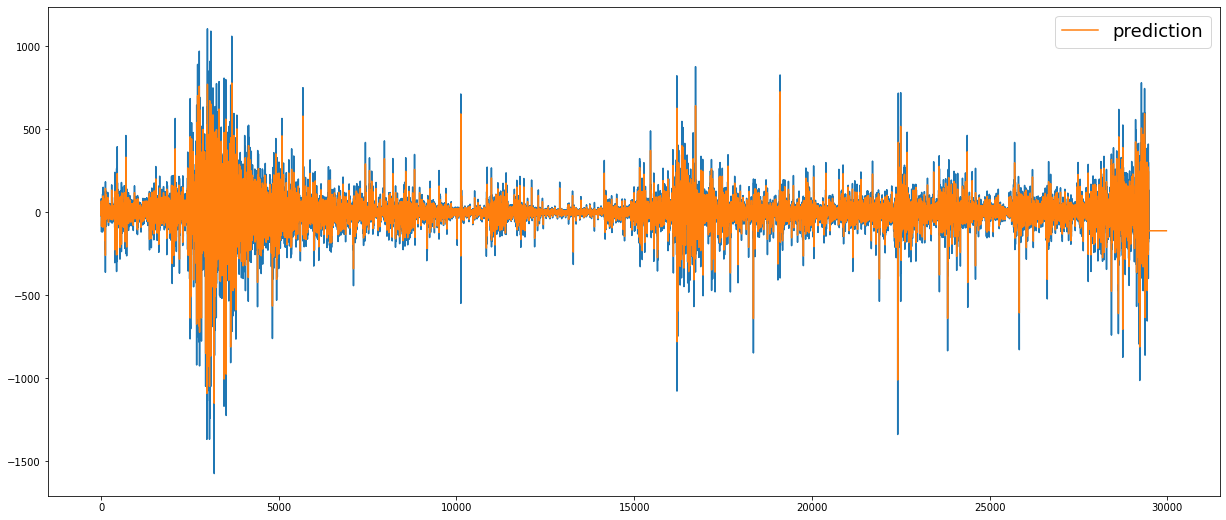

In [10]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing as SES

model_ses = SES(Open_stationary, initialization_method="heuristic").fit(smoothing_level=0.75)

predict_ses = model_ses.predict(0, len(Open_stationary)+500)

plt.figure(figsize=(21, 9))

plt.plot(Open_stationary)
plt.plot(predict_ses, label="prediction")

plt.legend(fontsize=18)


# Holt Winter’s Exponential Smoothing 

In [9]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model_hwes = ExponentialSmoothing(Open_stationary, trend = 'add').fit(smoothing_level=0.5)

predict_hwes = model_hwes.predict(0, len(Open_stationary) + 500)

plt.figure(figsize=(21, 9))

plt.plot(Open_stationary)
plt.plot(predict_hwes, 'red', label="predict")

plt.legend(fontsize=18)

/home/ufemah/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:578: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/home/ufemah/.local/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
/home/ufemah/.local/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


NameError: name 'Open_stat' is not defined